In [86]:
#importing all the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('ggplot')
import seaborn as sns
import IPython.display as dp
from IPython.display import Image
import itertools
import operator
import math
from scipy import stats
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')
import folium 

In [87]:
#list of the boroughs in NYC
bor_list = ['Manhattan', 'Queens', 'Brooklyn', 'Bronx', 'Staten Island', 'EWR']
#reading the dataset of boroughs and zones
cab_table = pd.read_csv('taxi%20_zone_lookup.csv')

In [88]:
#defining the year
year = 2018
#defining months and number of days per month (from january to june) as a tuple
month_list = [('January', 1, 31), ('February', 2, 28), ('March', 3, 31), ('April', 4, 30), 
              ('May', 5, 31), ('June', 6, 30)]

For a matter of memory we decide to import just the columns which we're interested in by using *usecols*. We also use *parse_dates* to work with the "tpep_pickup_datetime", "tpep_dropoff_datetime" strings as dates.

In [89]:
#function to read the single dataset
def import_file(month):
    #reading the dataset using 'usecols' to import only the useful columns
    return pd.read_csv('yellow_tripdata_2018-0' + str(month) + '.csv', 
                       parse_dates = ["tpep_pickup_datetime", "tpep_dropoff_datetime"],
                        #considering only the departure boroughs
                        usecols = ["tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", 
                                   "payment_type", "fare_amount", "PULocationID"]
                       )

In [90]:
#joining the dataset with the cab_table to get the borough corresponding to PULocationID
def join_files(dataset, table):
    return dataset.set_index('PULocationID').join(table.set_index('LocationID'))

We have to work on the trip's duration so we now compute this duration as the difference from the dropoff date and the pickup one, using the *astype* method in order to have time in seconds and adding these data to the complete dataframe as a new column.

In [91]:
#we will work on the duration of the trip
def compute_duration(complete_dataset):
    complete_dataset['trip_dur'] = (complete.tpep_dropoff_datetime 
                                    - complete.tpep_pickup_datetime).astype('timedelta64[s]') 

In order to work on the data we decide to divide the whole dataset into six dataframes, one for each borough, and to put it into a dictionary so that we can easily look at the infos about, let's say, Manhattan by accessing the values of the dictionary.

In [92]:
#creating a dictionary that contains the dataframe of each (separated) borough
def generate_bordict(complete_dataset, boroughs_list, month, year):
    bor_dict = {}
    for x in boroughs_list:
        #selecting the trips of that particular month and year with non negative distances, durations and fare amount
        bor_df = complete_dataset[(complete_dataset.Borough == x) & 
                                  (complete_dataset.tpep_pickup_datetime.dt.month == month) 
                         & (complete_dataset.tpep_pickup_datetime.dt.year == year) 
                                  & (complete_dataset.trip_distance > 0)
                        & (complete_dataset.trip_dur > 0) & (complete_dataset.fare_amount > 2.5)]
        bor_dict[x] = bor_df
    return bor_dict

We want want visualize the informations for all New York city via plots so we define a function which takes a sample from the complete dataset.

In [93]:
def sample_nyc(complete_dataset, month):
    #selecting the dataset of NYC 
    nyc_dataset = complete_dataset[(complete_dataset.tpep_pickup_datetime.dt.month == month) & 
                                   (complete_dataset.tpep_pickup_datetime.dt.year == year) &
                                   (complete_dataset.trip_distance > 0) & 
                                   (complete_dataset.fare_amount > 0) &
                                   (complete_dataset.trip_dur > 0)]
    return nyc_dataset.trip_dur[(nyc_dataset.trip_dur > 60) & 
                                (nyc_dataset.trip_dur < 6000)].sample(5000)

By applying the filters of positive durations, distances and fare amounts we notice that Staten Island and EWR have few valid data so we take the whole datasets of these boroughs and a sample of the other boroughs, like Manhattan which has about seven millions of valid trips.

In [94]:
def sample_borough(bor_dict, boroughs_list):
    sample_bor = []
    #some boroughs have few trips so we take all the data 
    for borough in boroughs_list:
        if borough == 'Staten Island' or borough == 'EWR':
            x_dep = bor_dict[borough]
            x_sample = x_dep.trip_dur[(x_dep.trip_dur > 60) & (x_dep.trip_dur < 6000)]
            sample_bor.append(x_sample)
        else:
            x_dep = bor_dict[borough]
            #we cannot take millions of data trips for borough Like Manhattan, so we take a sample
            x_sample = x_dep.trip_dur[(x_dep.trip_dur > 60) & (x_dep.trip_dur < 6000)].sample(5000)
            sample_bor.append(x_sample)
    return sample_bor

In [95]:
def rq_1(bor_dict, boroughs_list, num_days, trip_Tot, aver_Tot):
    #creating a dict to store the number of trips for each borough
    mydict_sum = {}
    #creating a dict to store the mean of trips for each borough per month
    mydict_mean = {}
    #selecting the df of the borough x
    for x in boroughs_list:
        bor_df = bor_dict[x]
        #the number of the rows per boroughs corresponds to the number of trips from that borough
        mydict_sum[x] = len(bor_df) 
        mydict_mean[x] = round(mydict_sum[x]/num_days, 2)
    #appending the number of trips and the average to the total lists
    trip_Tot.append(list(mydict_sum.values()))
    aver_Tot.append(list(mydict_mean.values()))
    return mydict_sum

In [96]:
def plot_rq1(aver_Tot): #it gives the plots for each month in the same box for each borough
    avg_df = pd.DataFrame(aver_Tot)
    avg_df.rename(columns = {0 : 'Manhattan', 1 : 'Queens', 2: 'Brooklyn', 3: 'Bronx', 
                             4: 'Staten Island', 5 : 'EWR'},
                  index = {0: 'January', 1:'February', 2:'March', 3:'April', 4:'May', 5:'June'}, 
                  inplace = True)
    avg_df.plot(kind='bar', log = True, title = 'Average number of trips in the boroughs', 
                figsize = (8, 4))
    plt.show()

We set up time slot of three hour to see what is the trend of the trips during the day and define a function to analyze the NYC dataset and one for the separated boroughs.

In [97]:
def rq_2nyc(complete_dataset):
    #creating a dict to store the number of passengers per time slot
    mydict_pass = {}
    #taking time slots of three hours
    for h in range(0, 24, 3):
        timeslot_df = complete_dataset[(complete_dataset.tpep_pickup_datetime.dt.hour >= h) &
                                       (complete_dataset.tpep_pickup_datetime.dt.hour < h + 3)]
        pass_count = timeslot_df['passenger_count'].sum()
        mydict_pass[h] = pass_count
        
    return mydict_pass

In [98]:
def rq_2(bor_dict, boroughs_list):
    #creating a dict to store the number of passengers per time slot
    mydict_pass = {}
    for x in boroughs_list:
        bor_df = bor_dict[x]
        subdict = {}
        #taking time slots of three hours
        for h in range(0, 24, 3):
            timeslot_df = bor_df[(bor_df.tpep_pickup_datetime.dt.hour >= h) & 
                                 (bor_df.tpep_pickup_datetime.dt.hour < h + 3)]
            pass_count = timeslot_df['passenger_count'].sum()
            subdict[h] = pass_count
        mydict_pass[x] = subdict
        
    return mydict_pass

In [99]:
def plot_rq2nyc(mydict_pass, month_list):
    fig, axes = plt.subplots(nrows = 2, ncols = 3,  figsize = (30, 8))
    plt.subplots_adjust(bottom = -0.8, right = 0.75, top = 0.7)
    ax0, ax1, ax2, ax3, ax4, ax5 = axes.flatten()
    ax_list = ax0, ax1, ax2, ax3, ax4, ax5
    #plt.subplots_adjust(bottom = -0.3, right = 0.8, top = 0.9)
    colors = ['wheat', 'khaki', 'gold', 'goldenrod', 'orange', 'coral', 'salmon', 'red']
    labels = ['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24']
    for month_name, month_number, month_len in month_list:
        month_data = mydict_pass[month_name]
        keys = list(month_data.keys())
        #print(month_data)
        for i in range(len(colors)):
            ax_list[month_number - 1].bar(keys[i], month_data[keys[i]], align='center',
                                   color = colors[i], label = labels[i])
        ax_list[month_number - 1].set_title(month_name)
        #ax_list[month_number - 1].set_xticklabels(labels[j] for j in range(8))
        ax_list[month_number - 1].legend(prop = {'size': 10})
        

In [100]:
def plot_rq2(pass_Time, month_list):
    fig, axes = plt.subplots(nrows = 6)
    plt.subplots_adjust(bottom = -0.2)
    passengers_list = []
    for month_name, month_number, month_len in month_list:
        sub_pass = []
        month_data = pass_Time[month_name]
        for borough in month_data.keys():
            sub_pass.append(list(month_data[borough].values()))
        passengers_list.append(sub_pass)

    passengers_df = []
    for el in passengers_list:
        passengers_df.append(pd.DataFrame(el))
        
    for index in range(6):
        passengers_df[index].rename(index =  {0 : 'Mnt', 1 : 'Que', 2: 'Brl', 3: 'Brx', 
                                              4: 'SI', 5: 'EWR'},
                        columns = {0: '0-3', 1: '3-6', 2: '6-9', 3: '9-12', 4: '12-15', 
                                   5: '15-18', 6: '18-21', 7: '21-24'}, inplace = True)
        passengers_df[index].plot(kind = 'bar',ax = axes[index],log = True,figsize = (15,17),
                                  title = month_list[index][0]) 

In [101]:
def plot_rq3nyc(nyc_dataset, month_list):
    plt.figure(figsize = (50, 40))
    fig, axs = plt.subplots(6, figsize=(25, 70))
    plt.subplots_adjust(bottom = -0.2)
    for i in range(len(nyc_dataset)):
        axs[i].set_title(month_list[i][0])
        sns.distplot(nyc_dataset[i], ax = axs[i])

In [102]:
def plot_rq3(sample_bor, boroughs_list, month_list):
    title_list = ['January', 'February', 'March', 'April', 'May', 'June']
    #we don't have enough data to take a unique sample
    #so we decide to take the same percentage of the data
    plt.figure(figsize = (1, 3))
    fig, axs = plt.subplots(6)
    plt.subplots_adjust(bottom = -5, right = 0.75, top = 0.9)
    for i in range(len(sample_bor)):  
        axs[i].set_title(month_list[i][0])
        for j in range(len(boroughs_list)):
            data_to_plot = pd.DataFrame(sample_bor[i][j])
            sns.distplot(data_to_plot, hist=False, label = boroughs_list[j], ax = axs[i])       

In [103]:
def rq_4(bor_dict, boroughs_list):
    payment = [1, 2, 3, 4]#, 5, 6]  we have no 5 and 6 payments recorded
    mydict_ = {} #creating a dict to store the payment type of each borough
    mydict_pay = {} #creating a dict to store the most common type of payments for each boroughs
    pay_list = []
    for x in boroughs_list:
        bor_df = bor_dict[x] #filter among the boroughs
        pay_type = {}
        li = []
        for p in payment:
            x_pay = bor_df[(bor_df.payment_type == p)]
            #number of payments for each pay type
            pay_type[p] = len(x_pay) 
            li.append(pay_type[p])
        mydict_[x] = pay_type
        #most common type of payments for each borough
        mydict_pay[x] = max(mydict_[x].items(), key = operator.itemgetter(1))[0]  
        pay_list.append(li)
    return pay_list

In [104]:
def plot_rq4(pay_list, month_list):
    fig, axes = plt.subplots(nrows = 6)
    plt.subplots_adjust(bottom = -0.2)
    pay_df = []
    for el in pay_list:
        pay_df.append(pd.DataFrame(el))
        
    for index in range(6):
        pay_df[index].rename(index =  {0 : 'Mnt', 1 : 'Que', 2: 'Brl', 3: 'Brx', 4: 'SI', 5: 'EWR'},
                        columns = {0: '1', 1: '2', 2: '3', 3: '4'},
                                      inplace = True)
        pay_df[index].plot(kind = 'bar', ax = axes[index], log = True, figsize = (15,17), 
                           title = month_list[index][0]) 

In [105]:
def chisquared_rq4(p_list):
    tab_chi = np.array(p_list)
    tab_cont = stats.chi2_contingency(tab_chi)
    return tab_cont 
    #the 1-st is the chi square statistic 
    #the 2-nd is the p-value used to determine significance
    #the 3-rd is the number of degrees of freedom
    #finally there's the contingency table

In [106]:
def rq_5(bor_dict, boroughs_list):
    #creating a dict to store the trip distance (of each borough)
    mydict_dist = {}
    for x in boroughs_list:
        bor_df = bor_dict[x]
        sub_dist = {}
        for row in range(len(bor_df)):
            dis = bor_df.get('trip_distance')
            sub_dist[row] = dis
        mydict_dist[x] = sub_dist

In [107]:
def plot_rq5(complete_dataset):
    sample_comp = complete_dataset[(complete_dataset['trip_dur'] > 120) & 
                                   (complete_dataset['trip_dur'] < 7000) & 
                                   (complete_dataset['trip_distance'] < 100)].sample(5000)
    sns.regplot(x = sample_comp['trip_dur'], y = sample_comp['trip_distance'], color = 'LightGreen')
    plt.show()
    return stats.pearsonr(sample_comp['trip_dur'], sample_comp['trip_distance']) 
    #it returns also the p value.

In [108]:
def price_per_mile(bor_dict, boroughs_list):
    mean_p = []
    var_p = []
    std_p = []
    mydict_price = {}
    for x in boroughs_list:
        bor_df = bor_dict[x]
        #computing the price for mile
        price_mile = bor_df.get('fare_amount') / bor_df.get('trip_distance')
        mydict_price[x] = list(price_mile)
        #creating a new column on the df
        bor_df['price_per_mile'] = price_mile
        #computing mean, var and std of the new variable
        mean = price_mile.mean()
        var = price_mile.var()
        mean_p.append(mean)
        var_p.append(var)
    for el in var_p:
        std_p.append(math.sqrt(el))
    return (mean_p, std_p, var_p)

In [109]:
def all_pairs(li): #it returns all the possible pairs of the elements of the list 
    return list(itertools.combinations(li, 2)) 

In [110]:
def t_test_mile(boroughs_list, bor_dict):
    alpha = 0.05 #our chosen significance level
    pairs = all_pairs(boroughs_list) 
    for bor_pair in pairs: #we compare all the possible pairs
        price1 = bor_dict[bor_pair[0]]['price_per_mile']
        price2 = bor_dict[bor_pair[1]]['price_per_mile']
        stat, p = ttest_ind(price1, price2)
        if p < alpha:
            print(bor_pair[0] + '-' + bor_pair[1] + ':' + str(p) + ', reject the null hypothesis')
        else: 
            print(bor_pair[0] + '-' + bor_pair[1] + ':' + str(p) + ', not reject the null hypothesis')

In [111]:
def weighted_price(bor_dict, boroughs_list):
    mean_w = []
    var_w = []
    std_w = []
    mydict_weight = {}
    for x in boroughs_list:
        bor_df = bor_dict[x]
        #computing the weighted price
        weight_p = bor_df.get('price_per_mile') / bor_df.get('trip_dur')
        mydict_weight[x] = list(weight_p)
        bor_df['w_price'] = weight_p
        mean_w.append(bor_df['w_price'].mean())
        var_w.append(bor_df['w_price'].var())
    for el in var_w:
        std_w.append(math.sqrt(el))
    return (mean_w, std_w, var_w)

In [112]:
def t_test_weighted(boroughs_list, bor_dict):
    alpha = 0.05
    pairs = all_pairs(boroughs_list) 
    for bor_pair in pairs:
        price1 = bor_dict[bor_pair[0]]['w_price']
        price2 = bor_dict[bor_pair[1]]['w_price']
        stat, p = ttest_ind(price1, price2)
        if p < alpha:
            print(bor_pair[0] + '-' + bor_pair[1] + ':' + str(p) + ', reject the null hypothesis')
        else: 
            print(bor_pair[0] + '-' + bor_pair[1] + ':' + str(p) + ', not reject the null hypothesis')

In [131]:
def plot_crq1_mile(bor_dict, boroughs_list):
    #we don't have enough data to take a unique sample
    #so we decide to take the same percentage of the data
    fig, ax = plt.subplots(nrows = 6)
    plt.subplots_adjust(bottom = -0.2)
    for index in range(6):
        for x in boroughs_list:
            if x == 'Bronx' or x == 'Staten Island' or x == 'EWR':
                data = bor_dict[x]['price_per_mile']
                data.plot(kind = 'density', xlim = (-30, 30), label = x, ax = ax[index], 
                          title = month_list[index][0], figsize = (15,17))
                ax[index].legend()
            else:
                samp = bor_dict[x]['price_per_mile'].sample(5000)
                samp.plot(kind = 'density', xlim = (-30, 30), label = x, ax = ax[index], 
                          title = month_list[index][0], figsize = (15,17))
                ax[index].legend()

In [133]:
def plot_crq1_weighted(bor_dict, boroughs_list):
    #we don't have enough data to take a unique sample
    #so we decide to take the sample
    fig, ax = plt.subplots(nrows = 6)
    plt.subplots_adjust(bottom = -0.2)
    for index in range(6):
        for x in boroughs_list:
            if x == 'Bronx' or x == 'Staten Island' or x == 'EWR':
                data = bor_dict[x]['w_price']
                data.plot(kind = 'density', xlim = (-0.25, 0.25), label = x, ax = ax[index],
                          title = month_list[index][0], figsize = (15,17))
                ax[index].legend()
            else:
                samp = bor_dict[x]['w_price'].sample(5000)
                samp.plot(kind = 'density', xlim = (-0.25, 0.25), label = x, ax = ax[index],
                          title = month_list[index][0], figsize = (15,17))
                ax[index].legend()

In [115]:
#the cycle to run the analysis for all the datasets

In [116]:
#creating the lists/dict to store the results for all the months
sample_allnyc = [] #list of samples of NYC trips per month
sample_bor = [] #list of samples of trips for each borough per month
num_passTOT = [] #list of numbers of trips per month
aver_listTOT = [] #list of average numbers of trips recorded each day per month
aver_listNyc = [] #list of average numbers of trips recorded each day per month in Nyc
pass_TimeNyc = {} #dict to store the results for all the months of all Nyc
pass_TimeTOT = {} #dict of numbers of passengers per time slot per month 
pay_TOT = [] #list of numbers of payments for each type per month
for month_name, month_number, month_len in month_list:
    print(month_name)
    first = import_file(month_number)
    complete = join_files(first, cab_table)
    compute_duration(complete)
    bor_dict = generate_bordict(complete, bor_list, month_number, year)
    sample_allnyc.append(sample_nyc(complete, month_number))
    sample_bor.append(sample_borough(bor_dict, bor_list))
    mydict_sum = rq_1(bor_dict, bor_list, month_len, num_passTOT, aver_listTOT)
    pass_TimeNyc[month_name] = rq_2nyc(complete)
    pass_TimeTOT[month_name] = rq_2(bor_dict, bor_list)
    pay_TOT.append(rq_4(bor_dict, bor_list))
    chi_tab = chisquared_rq4(pay_TOT)
    rq_5(bor_dict, bor_list)
    (mean_p, std_p, var_p) = price_per_mile(bor_dict, bor_list)
    print('t_test for the variable price_per_mile')
    t_test_mile(bor_list, bor_dict)
    print('t_test for the variable weighted_price')
    (mean_w, std_w, var_w) =  weighted_price(bor_dict, bor_list)
    t_test_weighted(bor_list, bor_dict)

January
t_test for the variable price_per_mile
Manhattan-Queens:3.381212925060387e-05, reject the null hypothesis
Manhattan-Brooklyn:0.025205612724799244, reject the null hypothesis
Manhattan-Bronx:0.0009445852438161174, reject the null hypothesis
Manhattan-Staten Island:0.06946552840617493, not reject the null hypothesis
Manhattan-EWR:0.0, reject the null hypothesis
Queens-Brooklyn:0.945601273021207, not reject the null hypothesis
Queens-Bronx:0.10443144108167844, not reject the null hypothesis
Queens-Staten Island:0.42608710001596894, not reject the null hypothesis
Queens-EWR:0.0, reject the null hypothesis
Brooklyn-Bronx:0.045558769878325696, reject the null hypothesis
Brooklyn-Staten Island:0.3203337724653361, not reject the null hypothesis
Brooklyn-EWR:0.0, reject the null hypothesis
Bronx-Staten Island:0.41321582628660836, not reject the null hypothesis
Bronx-EWR:2.925474627127881e-199, reject the null hypothesis
Staten Island-EWR:7.492260655368061e-05, reject the null hypothesis

Queens-EWR:0.0, reject the null hypothesis
Brooklyn-Bronx:2.511737660085522e-08, reject the null hypothesis
Brooklyn-Staten Island:0.43401578428806786, not reject the null hypothesis
Brooklyn-EWR:0.0, reject the null hypothesis
Bronx-Staten Island:0.981808561550383, not reject the null hypothesis
Bronx-EWR:4.8618002894999084e-287, reject the null hypothesis
Staten Island-EWR:6.666753511534787e-05, reject the null hypothesis
t_test for the variable weighted_price
Manhattan-Queens:6.7961382960516925e-93, reject the null hypothesis
Manhattan-Brooklyn:0.06687296855027454, not reject the null hypothesis
Manhattan-Bronx:0.00976286683437298, reject the null hypothesis
Manhattan-Staten Island:0.9070406695327782, not reject the null hypothesis
Manhattan-EWR:0.0, reject the null hypothesis
Queens-Brooklyn:0.0004877879202959949, reject the null hypothesis
Queens-Bronx:0.7984521849785786, not reject the null hypothesis
Queens-Staten Island:0.9356510951610961, not reject the null hypothesis
Queens-

First of all we take the dataframe for each borough and count how many rows are there, they represents the number of trips per month. Then we compute the mean to obtain the average number of trips for each borough per month. We repeat the analysis for all the month and put the results together in a plot.

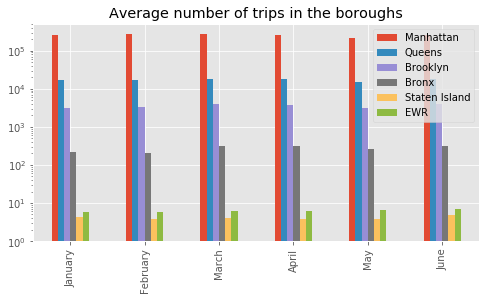

In [32]:
plot_rq1(aver_listTOT)

The plot shows the average number of trips for day in the months for each borough. By taking a look at it we can see that the trend of these values is roughly the same. The period in which taxis are used more is February-March but the differences between this and the others are not relevant. As we expected, Manhattan has the largest number of trips while Staten Island has the lowest. We also want to highlight that, although being an airport zone and not a properly borough (although considered as one), EWR has more average trips than Staten Island, which is surprising but not that much, because airports are commonly filled by taxis.

Let's see how the traffic changes during the day. We divide the day in time slots of three hours and count how many trips are there in each slot.
First of all we take a look on the plot of New York city.

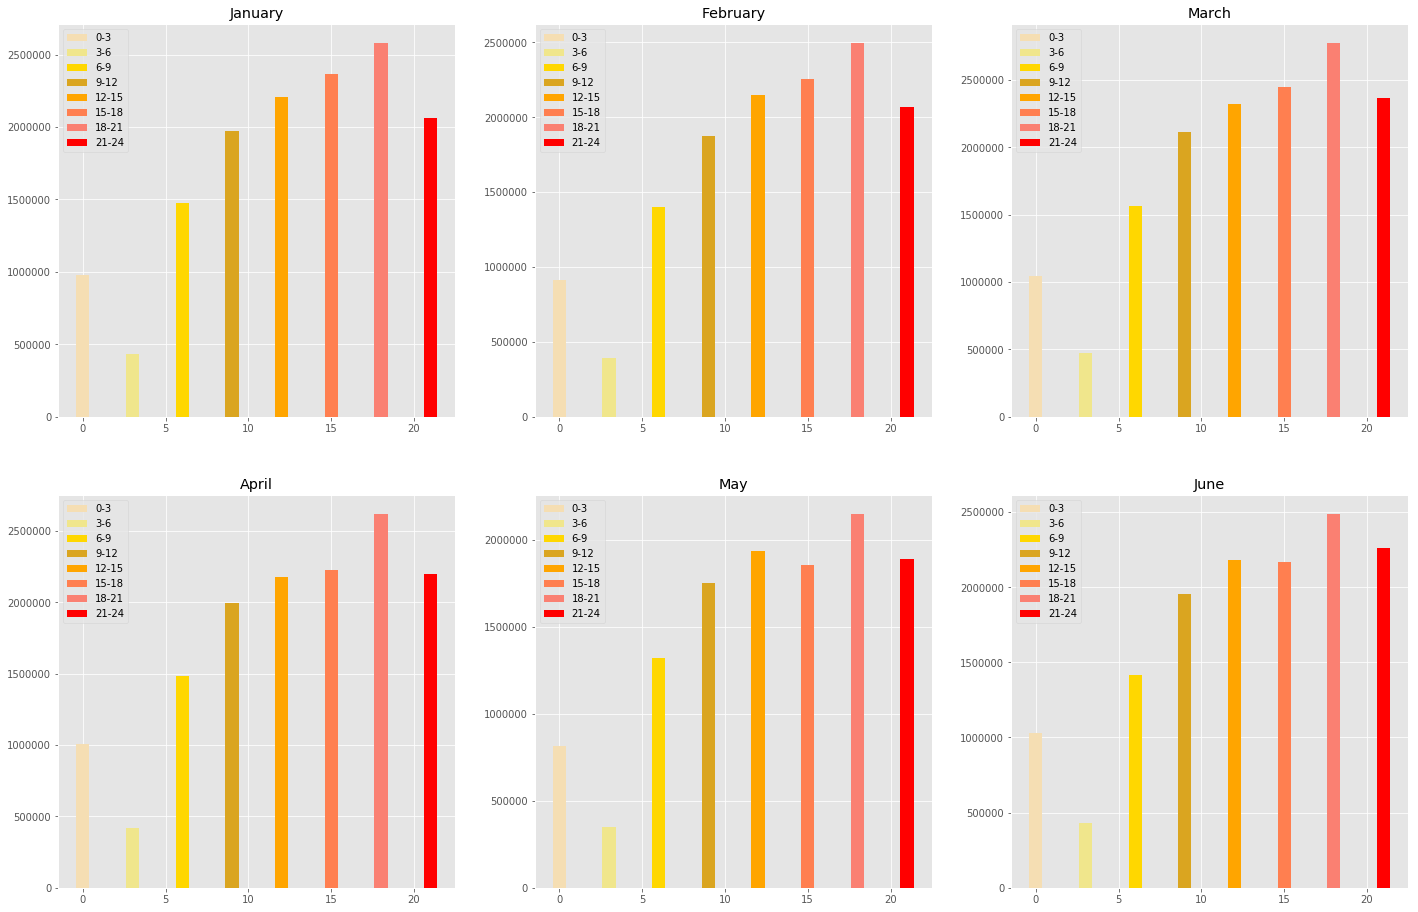

In [33]:
plot_rq2nyc(pass_TimeNyc, month_list)

As we can see from the plot the time slots with an intense traffic are from 9-12h to 21-24h, being 18-21h the most productive one. Our thinking is that these may be caused because more people come back home from work by taxi. We can also notice that the amount of trips in each time-slot doesn't vary much depending on the month, as all the amounts remain similar. Also, it seems that there is an increasing tendency of taking a taxi as the hour of the day advances. In almost all the months, the amount of trips increases by time-slot from 6-9h to 18-21h, and then it decreases till 6-9h, when it increases again. So, based on this we can say that allmost all of the taxi drivers follow this working schedule. 
To sum up, we conclude that the most productive time-slots occur during the day, concretely the evening, and less productive during the entire night and early in the morning.

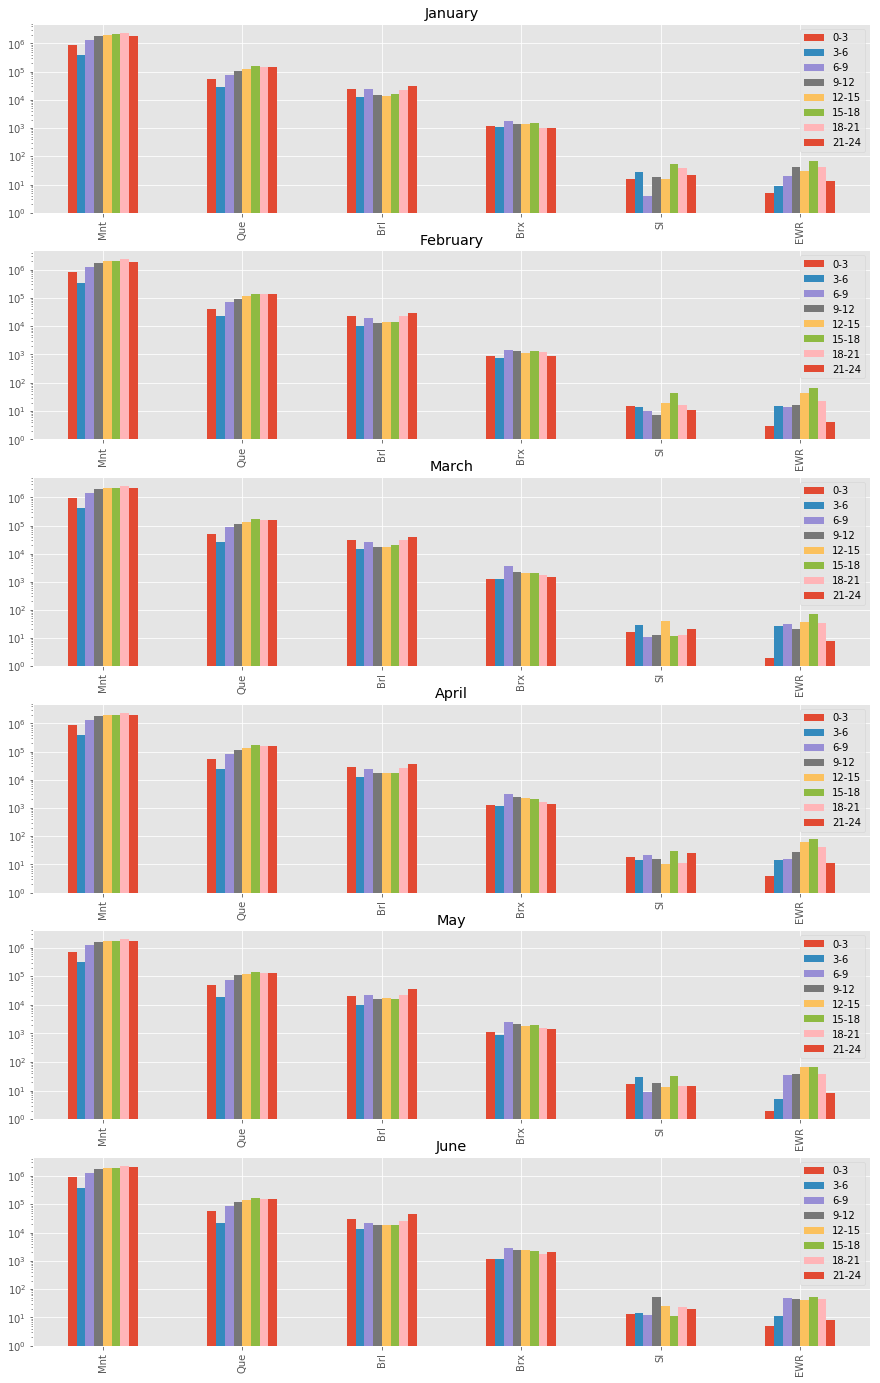

In [34]:
plot_rq2(pass_TimeTOT, month_list)

At first sight, we observe that Manhattan, Queens, Brooklyn and The Bronx maintain a stable amount of trips for each time-slot per month, while Staten Island and EWR have more volatile data as the most-productive time-slots during daytime vary according to the month. However, this may be caused because we have much less data of this two boroughs than the other ones. For example,we noticed that in January there are some millions of trips from Manhattan and about a hundred for Staten Island.  
Despite this, all the boroughs have an intense taxis traffic during the evening hours too, and in particular, Manhattan and Queens show the same trend of the whole NYC.
We also want to highlight that, unexpectingly, the most productive time-slots for Brooklyn are almost always 0-3h and 21-24h.

Now we are interested in the distribution of trips time duration in general. Since we have already compute the durations, we only visualize its distribution via a plot. First of all we look at New York city. We take a sample of 5000 trips whose durations last at least one minute and no more than an hour and a half: we filter the data this way because we know that the maximum distance between the two furthest boroughs is estimated to be about one hour and a half.

<Figure size 3600x2880 with 0 Axes>

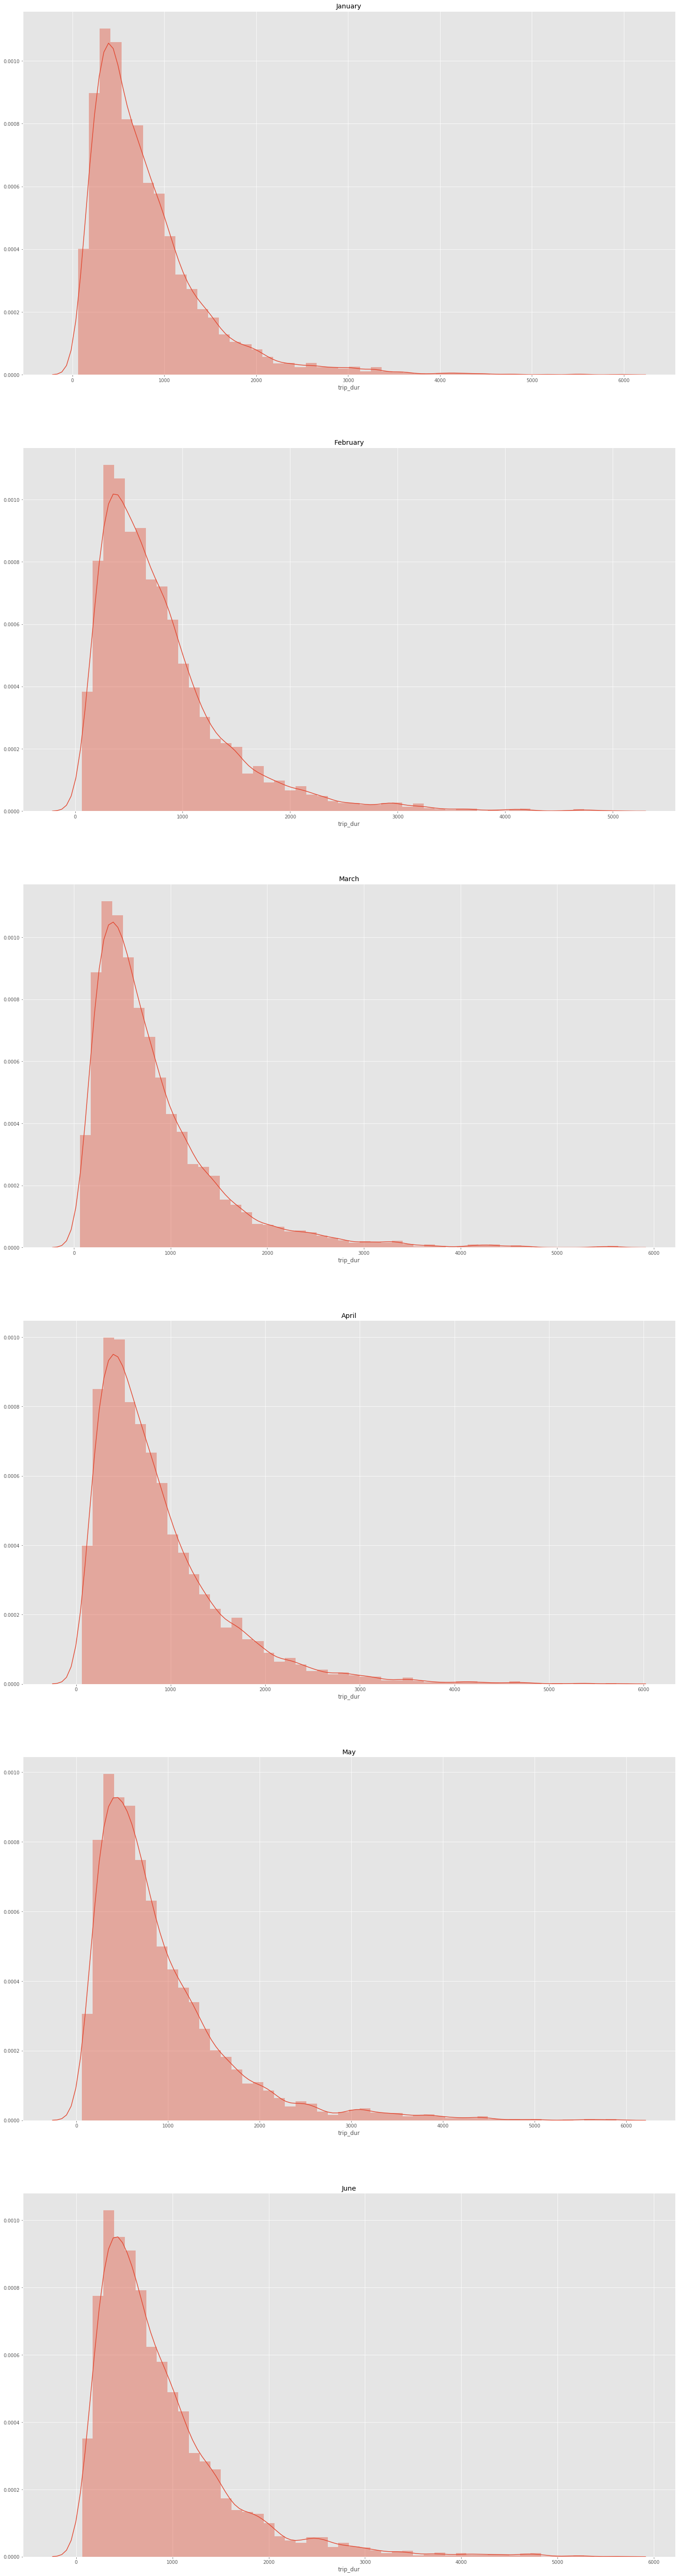

In [35]:
plot_rq3nyc(sample_allnyc, month_list)

As we can see this distribution is a chi squared. In particular we see that in New York in general the majority of the trips lies between 100 and 1000 seconds, so it's composed by short trips, while there are few trips with long durations. Our reasoning is that this is due to the extremely dense traffic and high parking difficulties, which causes that inside the city is far more comfortable to take a taxi instead of the car.
There are no significant differences in the distribution depending on months.

<Figure size 72x216 with 0 Axes>

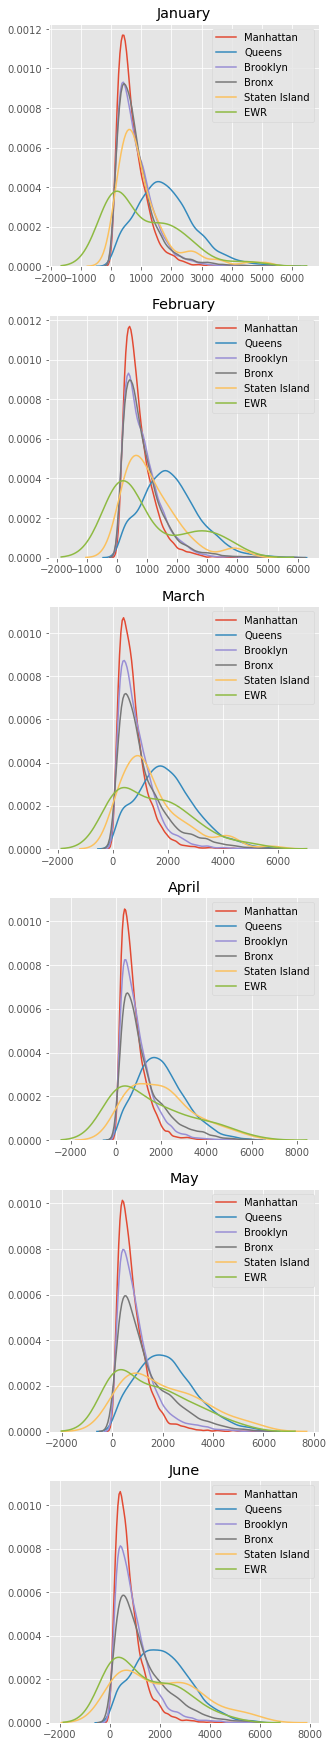

In [36]:
plot_rq3(sample_bor, bor_list, month_list)

For a matter of (clear) visualization we decide to make a distribution plot instead of an histogram.
As we have just seen for New York city, the trend of the trip duration for each borough is roughly the same except for Queens, which seems that the trips take a little longer(around 2000 secs).

Now we want to discover what is the most common type of payment in each borough. Once again we filter the data: we noticed that there are few payment types 5 and 6, 'Unknown' and 'Voided trip', and so we decide to remove them.

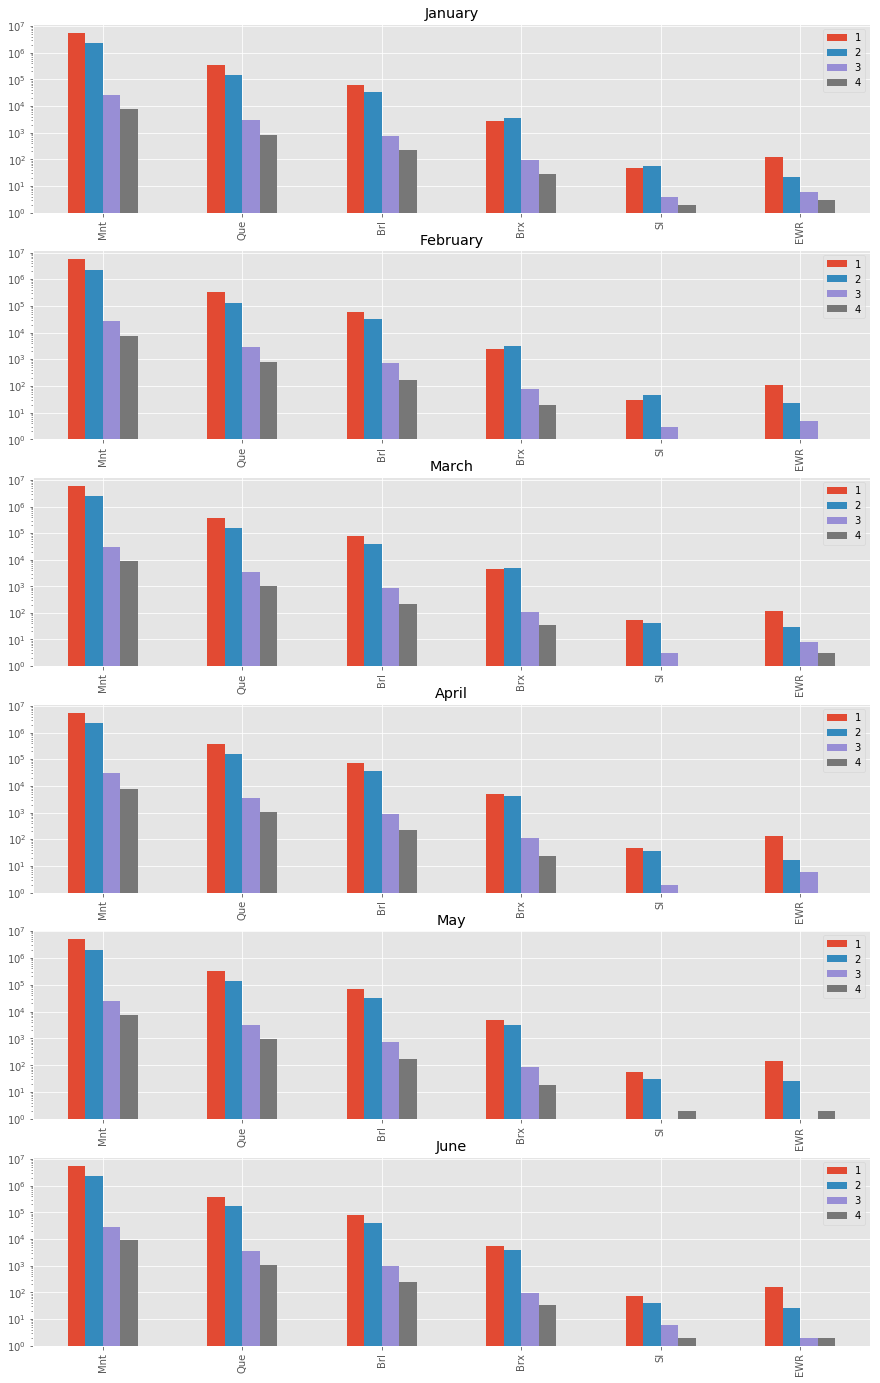

In [37]:
plot_rq4(pay_TOT, month_list)

We obtain that in general the most common way of payment is the credit card(1), except for Bronx and Staten Island which have a non regular trend about paying the taxis trips. However, we should take into account that cash payments(2) are also a highly used method of payment. This fact may be irrelevant at first sight, but we think is very important. Instead of credit card payments, cash payments allow taxi drivers to commit some irregularities, being the most common one not declaring the payment amount in its totality (as the transaction is not officially registered by any financial entity) in order to avoid taxation.
No charge(3) and dispute(4) have a residual role.
Furthermore we compute the chi squared test using stats.chi2_contingency that returns the chi square statistic, the p-value (used to determine significance), the number of degrees of freedom and finally the contingency table. We can see that the p value confirms that we have to reject the null hypothesis and accept the alternative one: they are dependent.

Finally we want to investigate the correlation between the distance and the trip duration. In order to do this we select once again trips with reasonable durations and distances. Naturally we cannot plot the distribution of all the data we have, so we take a sample of 5000 trips. Furthermore we compute the Pearson coefficient that represents the correlation between the trip distance and the trip duration. We use *stats.pearsonr* that gives two values: the Pearson coefficient and the p-value.  

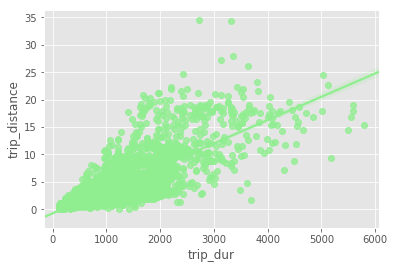

(0.8077569058581628, 0.0)

In [38]:
plot_rq5(complete)

There is a high correlation between the trip distance and the trip duration as our pearson coefficient is almost 0.8. To us, this high correlation makes sense, so that as a higher distance to cover, a higher duration of a trip.

## Core Research Question 1

Now we compute the price per mile. We divide the fare amount by the corresponding trip distance to compare the borough-to-borough expenditure and we compute the mean and the standard deviation. 

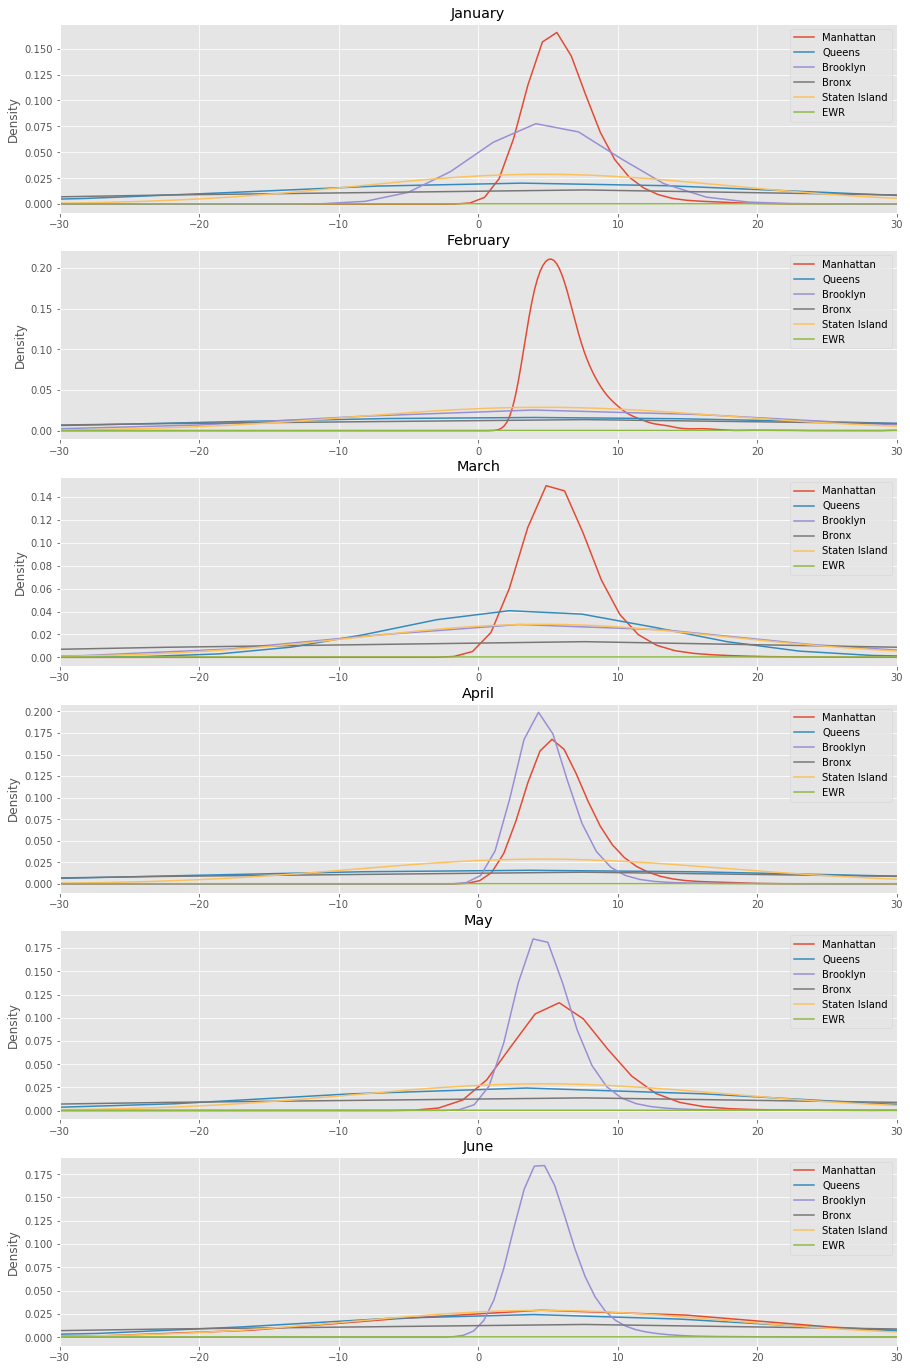

In [132]:
plot_crq1_mile(bor_dict, bor_list)

As always we take the whole set of trips for every borough, except Bronx, Staten Island and EWR: in fact these boroughs have a small number of valid trips (trip duration, distance and fare amount positive). 
We can see in general they have a gaussian trend.

Now we check the differences among all pairs of boroughs via t-test. We fix alpha = 0.05 which represents our significance level and compute the p values. By comparing the p values to alpha we know whether the null hypothesis has to be rejected or not. In our analysis the null hypothesis is that there are no significant differences between the means of each pair.
The results show that there are some similarities between the same pairs in different months but it's not possible to hypothize a general trend. At a further look at the results we can say that in general Manhattan reject the null hypothesis such as EWR. 
In particular we can take a look on the EWR dataset. It's composed by about a hundred trips data that show some anomalies (even though we filtered all the datasets).
For convenience (code) reason we print the p-values after the (for cycle) *main*.

The price_per_mile could be effected by the city's congestion. So we decide to weight the price_per_mile with the corresponding trip_duration. Then we run the same analysis for this new variable. 

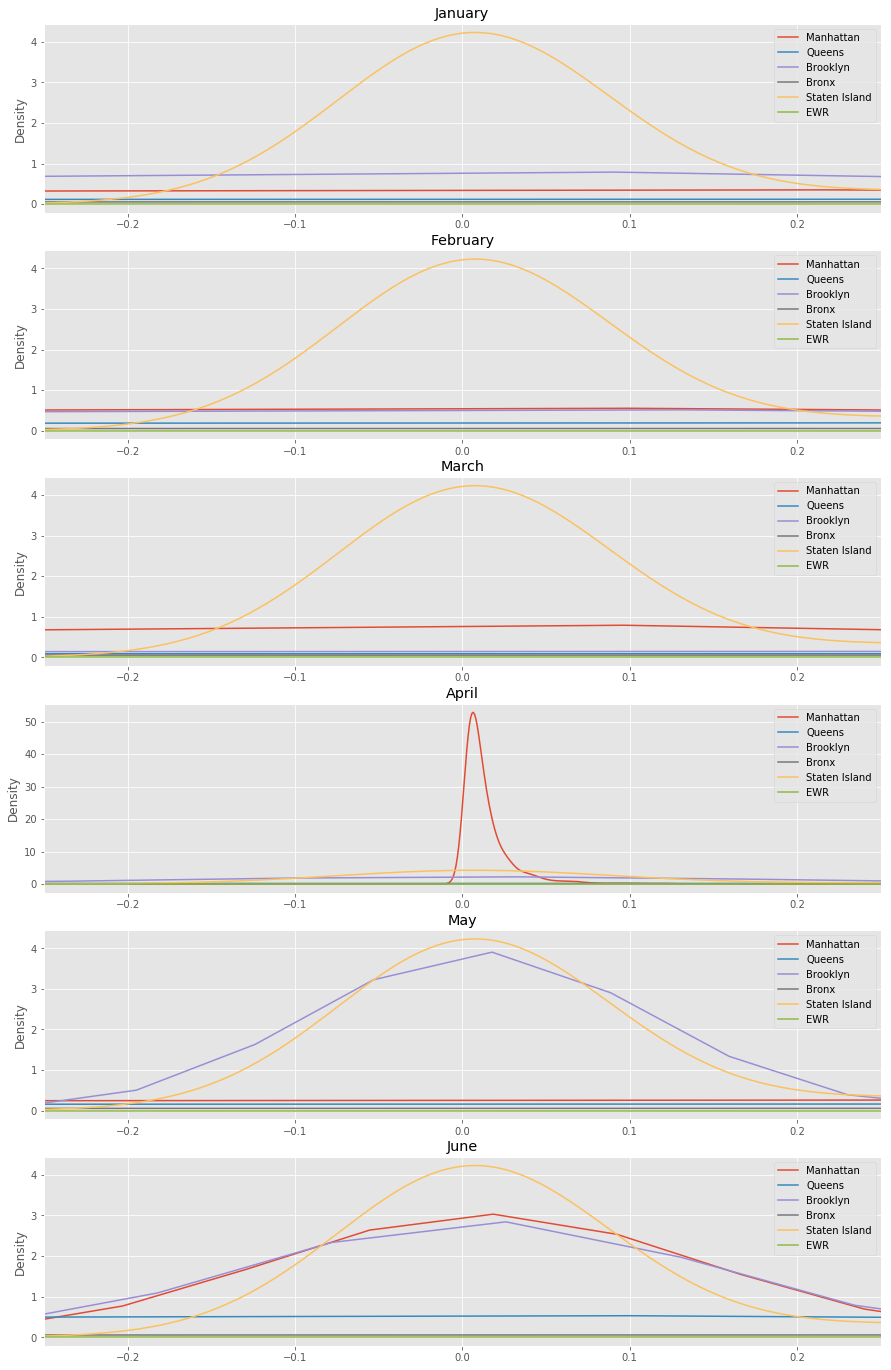

In [134]:
plot_crq1_weighted(bor_dict, bor_list)

Again the plot shows what looks like a gaussian distribution for this new variable. By taking a look on the results of the test we can say that Manhattan rejects the null hypothesis and EWR has (again) an anomalous trend. 

## Core Research Question 2

We now want to have a visualization of the taxis traffic both from the departure zones and the arrivals ones.
First we read all the dataframes and concatenate them (only the *PULocationID* and *DOLocationID* columns) into the *complete* one. Then we join this dataframe with *cab_table* dataframe to get the zones' names.

In [ ]:
#creating an empty list to store all the dataframes
all_dfs = []
for i in range(6):
    all_data = pd.read_csv('yellow_tripdata_2018-0' + str(i+1) + '.csv', usecols = ["PULocationID", "DOLocationID"])
    all_dfs.append(all_data)    

#concatenating the dataframes
complete = pd.concat([pd.DataFrame(all_dfs[i], columns = ['PULocationID','DOLocationID']) for i in range(6)])    

#joining the PULocationID with the corresponding Location ID
complete_PU = complete.set_index('PULocationID').join(cab_table.set_index('LocationID'))
#joining the DOLocationID with the corresponding Location ID
complete_crq2 = complete_PU.set_index('DOLocationID').join(cab_table.set_index('LocationID'), 
                                                           lsuffix = '_dep', rsuffix = '_arr')

We use the *groupby* function to group and count the occurrencies of each zone.

In [ ]:
#how many trips arrive in zones: counting the arr_zones
zone_count_dep = complete_crq2.groupby('Zone_dep').count()
zone_count_dep['Zone_dep_New'] = zone_count_dep.index
zone_count_dep = zone_count_dep[['Zone_dep_New','service_zone_dep']]
zone_count_dep.reset_index(inplace = True)

In [ ]:
#importing the json file
my_Taxi_map = os.path.join('taxi_zones.json')
taxi_jsn_map = json.load(open(my_Taxi_map))

In [ ]:
from branca.utilities import split_six
m = folium.Map([40.730610, -73.935242], zoom_start=12)

#choropleth is a function which help us to visualize our result.

m.choropleth(geo_data = taxi_jsn_map, 
                data = zone_count_dep,
                columns = ['Zone_dep_New','service_zone_dep'],
                key_on = 'properties.zone',
                fill_color = 'YlGnBu',
                fill_opacity = 0.7, 
                line_opacity = 0.2,
                legend_name = 'differents_taxi_zones',
                threshold_scale = [5,50,500,5000,50000]
                )
  
m.save('Departure_Zones_map.Html')

As we expected from the analysis above, Manhattan has the largest number of taxis trips. In particular we see a high density in the zones of Linden, LaGuardia Airport and, obviously, the J.F.K. airport while Staten Island shows a relevant traffic in Great Kills Park and Freshkills Park.

In [ ]:
#how many trips arrive in zones: counting the arr_zones
zone_count_arr = complete_crq2.groupby('Zone_arr').count()
zone_count_arr['Zone_arr_New'] = zone_count_arr.index
zone_count_arr = zone_count_arr[['Zone_arr_New','service_zone_arr']]
zone_count_arr.reset_index(inplace = True)

In [ ]:
from branca.utilities import split_six

m = folium.Map([40.730610, -73.935242], zoom_start=12)

#choropleth is a function which help us to visualize our result.

m.choropleth(geo_data = taxi_jsn_map, 
                data = zone_count_arr,
                columns = ['Zone_arr_New','service_zone_arr'],
                key_on = 'properties.zone',
                fill_color = 'YlOrRd',
                fill_opacity = 0.7, 
                line_opacity = 0.2,
                legend_name = 'differents_taxi_zones',
                threshold_scale = [5,50,500,5000,50000] 
            )
               
               
m.save('Arrival_Zones_map.Html')

We can see that Manhattan and Queens boroughs show an important amount of taxis trips. Again the airports (obviously) show a large number of trips, in particular Newark, La Guardia and J.F.K.  